# Bias Detection in News Articles

## Importing Required Libraries

In [1]:
import pandas as pd
import datetime 
from newsapi import NewsApiClient
import numpy as np
from newspaper import Article
import seaborn as sns
import matplotlib.pyplot as plt
from scipy import stats
from nltk.tokenize import word_tokenize
from nltk.tokenize import sent_tokenize
import nltk
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import RegexpTokenizer
from nltk.corpus import stopwords 
from nltk.corpus import wordnet
from urllib.parse import urlencode

## Fetching Real-Time News Article Contents - Google News API

The get_dataframe method is provided with the user's topic of interest. The new articles related to the topic in the given time frame are fetched from google news API. The JSON is processed and relevant information is converted into a dataframe for further processing.

In [21]:
#Datframe GENERATOR
def get_dataframe(search_term, from_date='2019-12-01', to_date='2019-12-07'):    
    newsapi = NewsApiClient(api_key='a3c4cafe7819435e8bc9e352724d5f6b')
#search_term ='impeachment'
    mydict = {'q': search_term}
    encoded_search = urlencode(mydict)
    domains = ['washingtonpost.com', 'nytimes.com', 'cnn.com', 'foxnews.com',
           'usatoday.com', 'npr.org', 'bloomberg.com','nypost.com','breitbart.com']    
    name = []
    author = []
    title =[]
    published_time = []
    url = []    
    for i in range(len(domains)):
        all_articles = newsapi.get_everything(q=search_term,
                                      domains= domains[i],
                                      from_param=from_date,
                                      to=to_date,
                                      language='en',
                                      sort_by='relevancy',
                                      page=1)        
        list_articles = all_articles['articles']
        for j in range(len(list_articles)):
            name.append(list_articles[j]['source']['name'])
            author.append(list_articles[j]['author'])
            title.append(list_articles[j]['title'])
            published_time.append(list_articles[j]['publishedAt'])
            url.append(list_articles[j]['url'])    
            text = []
    for i in range(len(url)):
        article = Article(url[i])
        print(i)
        try:
            article.download()
            article.parse()
            content = article.text
            text.append(content)
        except :
            text.append("")    
    newsarticle = pd.DataFrame()
    newsarticle['source'] = np.asarray(name)
    newsarticle['author'] = np.asarray(author)
    newsarticle['title'] = np.asarray(title)
    newsarticle['published_time'] = np.asarray(published_time)
    newsarticle['url'] = np.asarray(url)
    newsarticle['content'] = np.asarray(text)
    newsarticle['words'] = newsarticle['content'].str.split().str.len()    
    newsarticle = newsarticle[newsarticle['content'] != '']
    newsarticle = newsarticle[newsarticle['words'] > 100]    
    return newsarticle

## Text Processing using NLP Techniques

1. Tokenization
2. Stop Words Removal
2. Lemmatization
3. Parts of Speech tagging
4. Bag of Words

In [22]:
stop_words = set(stopwords.words('english'))
#BIAS_SCORE_ESTIMATOR
with open('bias-lexicon.txt', 'r') as f:
    # Strips leading and trailing whitespaces in text
    bias_lexicon = []
    for line in f.readlines():
        bias_lexicon.append(line.strip())
    bias_lexicon 

# Bias in a sentence 
def is_sentence_bias(sentence):
    """ Decides if a sentence contains bias word(s) or not.
    """
    wordsList = word_tokenize(sentence) 
    wordsList = [w for w in wordsList if not w in stop_words]    
    tagged = nltk.pos_tag(wordsList)
    for word in tagged:
        if "VB" in word[1]:
            for bias_word in bias_lexicon:
                lemmatizer=WordNetLemmatizer()
                lemma=lemmatizer.lemmatize(word[0].lower(), wordnet.VERB)
                if lemma == bias_word:
                    return True
    return False

# Bias in a document
def bias_score_estimator(row):
    """ Calculates a bias score for a news article per the bias lexicon.
    
    Arg: 
        Row: A news article in the news_article dataframe.
    Returns: 
        A bias score from 0 to 1 with 1 being the most biased.  
    """
    bias_sent_count=0
    sentences_list = sent_tokenize(row)
    for sentence in sentences_list:
        if is_sentence_bias(sentence):
            bias_sent_count+=1
    return bias_sent_count/len(sentences_list)
            

## A simple command line interface to interact with the System

In [ ]:
#USER_INTERFACE
def take_user_input():
    user_query=input('Enter your search query: ')
    user_dates=input("Do you have a specific timeframe in mind [If your answer is N, we will pull out the recent ones]: Type Y/N:")
    if user_dates=='N':
        end_date=datetime.date.today().strftime("%Y-%m-%d")
        start_date=datetime.date.today() - datetime.timedelta(days=5)
    elif user_dates=='Y':
        start_date=input("Please enter the start date: [format: 'yyyy-mm-dd']:")
        end_date=input("Please enter the end date: [format: 'yyyy-mm-dd']:")
    else:
        print("That's an invalid Input. Please enter a valid input")
        take_user_input()
    user_choice=int(input("Enter 1 if you want to retrieve based on news publication: \n"\
    "Enter 2 if you want to retrieve based on poltical spectrum: \n"\
    "Enter 3 if it doesn't matter: "))
    if user_choice==1:
        user_politics=None
        user_source=input("Please input the sources you want to check out:\n"\
                            "washingtonpost.com\n"\
                            "nytimes.com\n"\
                              "cnn.com \n"\
                          "foxnews.com\n"\
                           "usatoday.com\n"\
                            "npr.org\n"\
                          "bloomberg.com\n"\
                          "nypost.com\n"\
                          "breitbart.com")
    elif user_choice==2:
        user_source=None
        user_politics=input("Please input your choice: \n"\
                            "left\n"\
                            "right\n"\
                            "center\n")
    elif user_choice==3:
        user_source=None
        user_politics=None
    else: 
        print("That's an invalid Input. Please enter a valid input")
        take_user_input()
    user_bias=int(input("Enter your bias score order preference: \n"\
                    "1->retrieve in ascending order\n"\
                    "2-> retrieve in descending order\n"))
    user_bias_from_range=float(input("Enter your bias score range from preference: (Specify between range 0.1 and 1) \n"))
    user_bias_to_range=float(input("Enter your bias score range to preference: (Specify a range between 0.1 and 1)  \n"))
    user_num=int(input("Specify the number of articles to be retrieved: "))
    return [user_query, start_date, end_date, user_source, user_politics, user_bias, user_bias_from_range, user_bias_to_range, user_num]

In [24]:
#ADDITIONAL COLUMNS
def bias_retrieve(src):
    side_dict = {'The Washington Post': 'left', 'The New York Times': 'left', 'CNN': 'left', 'Fox News': 'right',
               'USA Today': 'centre', 'Npr.org':'centre', 'Bloomberg':'center','Nypost.com': 'right','Breitbart News':'right'}
    return side_dict[src]
def add_columns(df):
    df['bias_side']=df['source'].apply(bias_retrieve)
    df['bias_score']=df['content'].apply(bias_score_estimator)
    return df

## The Information Retrieval System

In [25]:
#RETRIEVAL
def user_retrieval(user_prefs, news_trunc):
    if user_prefs[3]!=None:
        news_trunc=news_trunc[news_trunc['source']==user_prefs[3]]
    elif user_prefs[4]!=None:
        news_trunc=news_trunc[news_trunc['bias_side']==user_prefs[4]]
    news_trunc=news_trunc[(news_trunc['bias_score']>=user_prefs[6])&(news_trunc['bias_score']<=user_prefs[7])]
    if user_prefs[5]==1:
        news_trunc.sort_values(by=['bias_score'], inplace=True)
    else:
        news_trunc.sort_values(by=['bias_score'], ascending=False, inplace=True)
    news_trunc=news_trunc[0:user_prefs[8]]
    return news_trunc

## Project Demo

In [ ]:
#DEMO
user_prefs=take_user_input()
#news=get_dataframe(user_prefs[0], user_prefs[1], user_prefs[2])
#news.to_csv(r'primary.csv', header = True)
#news=add_columns(news)
news_df=user_retrieval(user_prefs, news)

Enter your search query: impeachment
Do you have a specific timeframe in mind [If your answer is N, we will pull out the recent ones]: Type Y/N:N
Enter 1 if you want to retrieve based on news publication: 
Enter 2 if you want to retrieve based on poltical spectrum: 
Enter 3 if it doesn't matter: 2
Please input your choice: 
left
right
center
left
Enter your bias score order preference: 
1->retrieve in ascending order
2-> retrieve in descending order
1
Enter your bias score range from preference: (Specify between range 0.1 and 1: 
0
Enter your bias score range to preference: (Specify a range between 0.1 and 1:  
1


## Displaying the Results

In [32]:
#DISPLAY
def display_df(trunc_df):
    i=1
    print("****** LIST OF NEWS ARTICLES ******")
    print("\n")
    for index,row in trunc_df.iterrows():
        print(i)
        i+=1
        print("HEADLINE:", row['title'])
        print("PUBLICATION:", row['source'])
        print("BIAS_SCORE:", row['bias_score'])
        print("URL:", row['url'])
        print("\n")

In [33]:
display_df(news_df)

****** LIST OF NEWS ARTICLES ******


1
HEADLINE: Marvin Miller’s Hall of Fame nod overshadows Yankees snub
PUBLICATION: Nypost.com
BIAS_SCORE: 0.4
URL: https://nypost.com/2019/12/08/marvin-millers-hall-of-fame-nod-overshadows-yankees-snub/


2
HEADLINE: Rep. Elise Stefanik (R-NY) On The Left’s Vicious Attacks & The Answers She is Demanding From Adam Schiff
PUBLICATION: Fox News
BIAS_SCORE: 0.4247311827956989
URL: https://radio.foxnews.com/2019/12/05/rep-elise-stefanik-r-ny-on-the-lefts-vicious-attacks-the-answers-she-is-demanding-from-adam-schiff/


3
HEADLINE: Republicans’ disdain for intellectualism was on display in Wednesday’s hearing
PUBLICATION: The Washington Post
BIAS_SCORE: 0.42857142857142855
URL: https://www.washingtonpost.com/politics/2019/12/06/republicans-disdain-intellectualism-was-display-wednesdays-hearing/


4
HEADLINE: ‘We Are Fleeing the Law’: Hong Kong Protesters Escape to Taiwan
PUBLICATION: The New York Times
BIAS_SCORE: 0.4390243902439024
URL: https://www.nytim

## Graphical Visualization

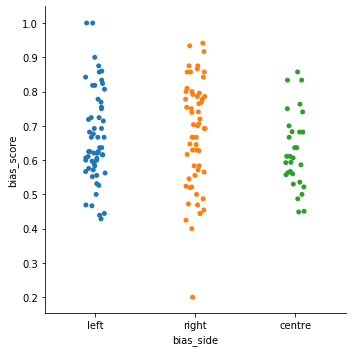

In [34]:
#Overview
sns.catplot(x="bias_side", y="bias_score",  jitter=True, data=news)

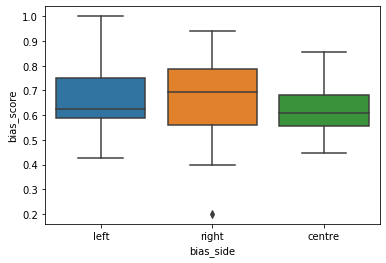

In [35]:
sns.boxplot(x="bias_side", y="bias_score", data=news)